In [103]:
import numpy as np
import pandas as pd 
import sys
import os 
import pickle
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense,BatchNormalization, Dropout
from tensorflow.keras.metrics import AUC
# from tensorflow.keras.experimental import CosineDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.callbacks import EarlyStopping
import sklearn.metrics as sklm
seed = 19
np.random.seed(seed)
tf.random.set_seed(seed)


In [104]:
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('__file__'), os.pardir)))

In [105]:
root_dir = os.path.dirname(os.path.dirname('__file__'))
print(root_dir)

## 1.MIMIC

In [106]:
medclip_embedding_folder = os.path.join(root_dir,"biomedclip-embedding")
os.makedirs(medclip_embedding_folder, exist_ok=True)
medclip_embedding_path = os.path.join(
    medclip_embedding_folder, "embedding_from_biomedclip_MIMIC.pkl")
print(medclip_embedding_path)

biomedclip-embedding\embedding_from_biomedclip_MIMIC.pkl


In [107]:
metadata_df=pd.read_csv("../MIMIC/df_final_for_metadata_prediction.csv")

In [108]:
metadata_df['ids'] = range(len(metadata_df))
metadata_df=metadata_df[['ids','path']]
metadata_df

,ids,path
0,0,files/p10/p10000032/s50414267/02aa804e-bde0afd...
1,1,files/p10/p10000032/s53189527/2a2277a9-b0ded15...
2,2,files/p10/p10000032/s53911762/68b5c4b1-227d048...
3,3,files/p10/p10000032/s53911762/fffabebf-74fd3a1...
4,4,files/p10/p10000032/s56699142/ea030e7a-2e3b134...
...,...,...
200447,200447,files/p19/p19999287/s53255195/431c5823-ea54bba...
200448,200448,files/p19/p19999287/s53282218/5a5eddf4-b64e5e4...
200449,200449,files/p19/p19999287/s58938059/2eb70dfe-52fa728...
200450,200450,files/p19/p19999442/s58497551/ee9155f3-944c056...


In [109]:
print('=============================== Load embedding and target ======================================')
if os.path.exists(medclip_embedding_path):
    with open(medclip_embedding_path, 'rb') as f:
        X, y, valid_id, ids = pickle.load(f)

=============================== Load embedding and target ======================================


In [110]:
# X is 2D numpy array of shape (200452, 512) 
bioClipdf = pd.DataFrame({
    'ids': range(len(X)),        # Create an 'id' column starting from 0
    'emb': list(X),# The 'emb' column holds the embeddings
})
bioClipdf.columns = ['ids', 'emb']

In [51]:
df_MIMIC=bioClipdf.merge(metadata_df,on='ids')
df_MIMIC = df_MIMIC[~df_MIMIC['emb'].apply(lambda x: np.all(np.array(x) == 0.0))]

In [52]:
processed_mimic_df=pd.read_csv("../MIMIC/processed_mimic_df.csv")
processed_mimic_df.head(2)

,path,subject_id,study_id,dicom_id,split,gender,insurance,age_decile,race,Enlarged Cardiomediastinum,...,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,No Finding
0,files/p14/p14174495/s51234155/2404c1ab-a3b40cd...,14174495,51234155,2404c1ab-a3b40cde-0c825331-769edf1e-2d99b2cf,train,M,Medicare,60-80,WHITE,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,files/p12/p12958709/s57422323/cc870a3a-f53f453...,12958709,57422323,cc870a3a-f53f453b-2ac5395a-ac1794e8-e0c0bba8,train,F,Other,20-40,HISPANIC/LATINO,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [53]:
df_MIMIC=df_MIMIC.merge(processed_mimic_df,on='path')

In [54]:
labels_Columns = ['Enlarged Cardiomediastinum', 'Cardiomegaly',
                    'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
                    'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other',
                    'Fracture', 'Support Devices', 'No Finding']

In [55]:
# Define the desired order of columns
columns_order = ['path','subject_id','gender',
                'age_decile','race','emb','Enlarged Cardiomediastinum','Cardiomegaly',
                'Lung Opacity','Lung Lesion','Edema','Consolidation','Pneumonia',
                'Atelectasis','Pneumothorax','Pleural Effusion','Pleural Other',
                'Fracture','Support Devices','No Finding']

df_MIMIC[labels_Columns] = df_MIMIC[labels_Columns].replace(-1.0, 0.0)

# Reorder the columns in the merged DataFrame
df_MIMIC = df_MIMIC[columns_order]
df_MIMIC.head(2)

,path,subject_id,gender,age_decile,race,emb,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,No Finding
0,files/p10/p10000032/s50414267/02aa804e-bde0afd...,10000032,F,40-60,WHITE,"[-3.243478298187256, 0.1761307716369629, -23.6...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,files/p10/p10000032/s53189527/2a2277a9-b0ded15...,10000032,F,40-60,WHITE,"[-2.612617254257202, 0.1668764352798462, -24.3...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## 2.CheXpert

In [61]:
os.makedirs(medclip_embedding_folder, exist_ok=True)
medclip_embedding_path = os.path.join(
    medclip_embedding_folder, "embedding_from_biomedclip_CXP.pkl")
print(medclip_embedding_path)

biomedclip-embedding\embedding_from_biomedclip_CXP.pkl


In [62]:
metadata_df = pd.read_csv("../CheXpert/dataframes/chexpert_df.csv")
metadata_df['ids'] = range(len(metadata_df))

In [63]:
print('=============================== Load embedding and target ======================================')
if os.path.exists(medclip_embedding_path):
    with open(medclip_embedding_path, 'rb') as f:
        X, y, valid_id, ids = pickle.load(f)
        
bioClipdf = pd.DataFrame({
    'ids': range(len(X)),        # Create an 'id' column starting from 0
    'emb': list(X),  # The 'emb' column holds the embeddings
})
bioClipdf.columns = ['ids', 'emb']

bioClipdf = bioClipdf[~bioClipdf['emb'].apply(
    lambda x: np.all(np.array(x) == 0.0))]

df = bioClipdf.merge(metadata_df, on='ids', how="inner")
df = df[~df['emb'].apply(lambda x: np.all(np.array(x) == 0.0))]

# Define the desired order of columns
# Define the desired order of columns
columns_order = ['Path', 'race', 'Sex', 'age_decile', 'Frontal/Lateral', 'AP/PA', 'emb',
                    'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation',
                    'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other',
                    'Fracture', 'Support Devices', 'No Finding']
# Reorder the columns in the merged DataFrame
df_CXP = df[columns_order]

df_CXP[labels_Columns] = df_CXP[labels_Columns]
df_CXP['path_splited'] = df_CXP['Path'].str.split('/')
df_CXP['patientid'] = df_CXP['path_splited'].apply(lambda x: x[2])

df_CXP.rename(columns={"Path":"path","Sex":"gender"},inplace=True)
# Insert 'patient_id' column at the second position
df_CXP.insert(1, 'patient_id', df_CXP['patientid'])

# Drop the intermediate 'path_splited' column
df_CXP.drop('path_splited', axis=1, inplace=True)
df_CXP.drop('patientid', axis=1, inplace=True)
df_CXP[labels_Columns] = df_CXP[labels_Columns].replace(-1.0, 0.0)

columns_order = ['path','patient_id','gender',
                'age_decile','race','emb','Enlarged Cardiomediastinum','Cardiomegaly',
                'Lung Opacity','Lung Lesion','Edema','Consolidation','Pneumonia',
                'Atelectasis','Pneumothorax','Pleural Effusion','Pleural Other',
                'Fracture','Support Devices','No Finding']

df_CXP = df_CXP[columns_order]

df_CXP.head(2)



=============================== Load embedding and target ======================================


C:\Users\gebre\AppData\Local\Temp\ipykernel_16480\3703636405.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CXP[labels_Columns] = df_CXP[labels_Columns]
C:\Users\gebre\AppData\Local\Temp\ipykernel_16480\3703636405.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CXP['path_splited'] = df_CXP['Path'].str.split('/')
C:\Users\gebre\AppData\Local\Temp\ipykernel_16480\3703636405.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

,path,patient_id,gender,age_decile,race,emb,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,No Finding
0,CheXpert-v1.0-small/train/patient39734/study6/...,patient39734,Male,60-80,Unknown,"[-1.7497394, -1.9795263, -17.179564, 3.4700758...",0,0,1,0,0,0,0,0,0,1,0,0,0,0
1,CheXpert-v1.0-small/train/patient29203/study7/...,patient29203,Male,60-80,WHITE,"[-1.6847723, 1.0133426, -22.10587, -0.21087989...",0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [64]:
df_MIMIC.rename(columns={"subject_id":"patient_id"},inplace=True)
df_MIMIC["patient_id"]=df_MIMIC["patient_id"].astype("object")
df_MIMIC[labels_Columns]=df_MIMIC[labels_Columns].astype("int64")
df=pd.concat([df_MIMIC,df_CXP],ignore_index=True)



In [77]:
unique_pathId = df.patient_id.unique()

train_percent, valid_percent, test_percent = 0.80, 0.10, 0.10

unique_path_id = shuffle(unique_pathId)
value1 = (round(len(unique_path_id)*train_percent))
value2 = (round(len(unique_path_id)*valid_percent))
value3 = value1 + value2
value4 = (round(len(unique_path_id)*test_percent))

In [78]:
print("Patients in training set: " + str(value1))

Patients in training set: 84066


In [79]:
print("Patients in validation set: " + str(value2))

Patients in validation set: 10508


In [80]:
print("Patients in testing set: " + str(value4))

Patients in testing set: 10508


In [81]:
df = shuffle(df)

train_path_id = unique_path_id[:value1]
validate_path_id = unique_path_id[value1:value3]
test_path_id = unique_path_id[value3:]

print(type(train_path_id))
print(train_path_id)

<class 'numpy.ndarray'>
['patient33870' 'patient01447' 10611307 ... 'patient39090' 'patient33795'
 18001923]


In [82]:
df.insert(7, "split","none", True)

In [83]:
df.loc[df.patient_id.isin(train_path_id), "split"]="train"
df.loc[df.patient_id.isin(validate_path_id), "split"]="validate"
df.loc[df.patient_id.isin(test_path_id), "split"]="test"


In [84]:
df.split.value_counts()

split
train       337996
validate     43327
test         41728
Name: count, dtype: int64

In [85]:
df_train = df[df["split"] == "train"]
df_validate = df[df["split"] == "validate"]
df_test = df[df["split"] == "test"]

In [86]:
# Create tf.data.Dataset objects for the datasets
train_dataset = tf.data.Dataset.from_tensor_slices((df_train.emb.values.tolist(), df_train[labels_Columns].values))

for train in train_dataset.take(1):
  print(train)

(<tf.Tensor: shape=(512,), dtype=float32, numpy=
array([ -2.5668132 ,   3.3376114 , -17.45713   ,  -0.1537404 ,
        -1.0202746 ,   5.6671886 ,  -3.6733937 ,   1.6060902 ,
        -0.57561624,  -0.7018886 ,   0.15520597,   2.1302204 ,
        -3.812575  ,  -2.9397511 ,   0.6689595 ,  -5.828928  ,
         0.5838661 ,   2.841764  ,  -4.813053  ,   2.997868  ,
        -4.694722  ,  -0.66701007,  -0.07676044,  -2.1667905 ,
        -6.5626564 ,   0.04360056,  -1.732234  ,  -4.1040344 ,
         2.204118  ,  -3.7574205 ,   2.2032378 ,   1.4611942 ,
         0.74081016,  -1.0757103 ,   3.7223134 ,   2.1799524 ,
         2.7873824 ,   4.2032256 ,  -3.8486238 ,   0.1526711 ,
         0.8955574 ,  -5.416403  ,  -1.1011657 ,   1.753128  ,
         0.89647514,   4.3103967 ,   2.3865094 ,  -1.473428  ,
         1.8647995 ,  -1.3129363 ,  -7.919634  ,   1.1315198 ,
        -2.1564455 ,   0.50113326,   2.4741168 ,   0.6506914 ,
        -2.7536607 ,   2.9612918 ,   1.289252  ,   1.6296126 ,
      

In [87]:

# Create tf.data.Dataset objects for the datasets
validation_dataset = tf.data.Dataset.from_tensor_slices((df_validate.emb.values.tolist(), 
                                                         df_validate[labels_Columns].values))

for val in validation_dataset.take(1):
  print(val)

(<tf.Tensor: shape=(512,), dtype=float64, numpy=
array([-3.70386386e+00, -2.26364779e+00, -2.04350128e+01, -3.12213516e+00,
       -2.19523430e+00,  2.03860497e+00, -2.40050077e+00,  1.71816897e+00,
        1.58263966e-01, -3.18572330e+00,  5.56958914e-01,  1.30193758e+00,
       -5.58962703e-01,  1.33057678e+00,  4.62048912e+00, -2.43137693e+00,
        7.86170244e-01,  2.22714019e+00, -3.71620923e-01,  1.13945436e+00,
       -3.63368464e+00, -5.43985844e+00,  8.99232745e-01,  1.40070486e+00,
       -6.15634441e+00, -3.32589388e+00,  3.41293287e+00,  2.39021719e-01,
        5.09089041e+00,  5.60514927e-02,  2.20479071e-01,  7.54514575e-01,
       -2.01600909e-01,  9.28022385e-01,  2.00496912e-02,  2.73706651e+00,
        2.98189807e+00, -1.69976711e+00, -4.48453522e+00, -1.69251132e+00,
        1.68870974e+00, -6.60187244e+00, -8.88534927e+00, -9.23466682e-01,
        6.37849450e-01,  3.54041290e+00,  6.06734037e-01,  9.51344490e-01,
       -2.98164773e+00, -9.33787465e-01, -5.3432507

In [88]:
# Create tf.data.Dataset objects for the datasets
test_dataset = tf.data.Dataset.from_tensor_slices((df_test.emb.values.tolist(), 
                                                         df_test[labels_Columns].values))
for test in test_dataset.take(1):
  print(test)

(<tf.Tensor: shape=(512,), dtype=float64, numpy=
array([-2.69063807e+00,  7.15572238e-01, -2.47999115e+01, -1.15933669e+00,
       -2.23780781e-01,  1.58498800e+00, -4.81411338e-01,  3.87124014e+00,
       -2.32895803e+00, -5.79245687e-01,  7.89929569e-01, -1.17849636e+00,
       -2.37551999e+00, -1.94882059e+00,  4.72829342e+00, -4.87515831e+00,
       -2.60817981e+00,  4.03175592e+00, -2.01916170e+00,  8.57182503e-01,
       -1.09609413e+00, -4.25875902e+00,  1.17654991e+00, -9.00200725e-01,
       -4.20462656e+00,  2.25605345e+00, -4.78698587e+00, -2.14465523e+00,
        3.46736574e+00, -2.98005152e+00,  4.93837297e-01,  4.04160619e-01,
       -1.00688887e+00, -5.64610362e-01,  1.85846889e+00,  2.78353333e+00,
        6.22112608e+00,  2.73135233e+00, -8.97708893e+00, -1.68338346e+00,
        1.18266451e+00, -7.25004435e-01, -1.83856583e+00,  1.89449906e-01,
        4.52247429e+00,  2.10773396e+00,  1.78973258e+00, -2.38429523e+00,
       -2.30535913e+00, -1.05509400e+00, -6.3262248

In [89]:
df_test=df_test.drop(columns='emb',axis=1)
df_validate=df_validate.drop(columns='emb',axis=1)

In [90]:
df_validate.to_csv("./biomedclip-embedding/df_validate.csv",index=False)
df_test.to_csv("./biomedclip-embedding/df_test.csv",index=False)

In [91]:
# These parameters are obtained by doing hyperparameter tuning 
embeddings_size=512
learning_rate=0.0001253
batch_size = 256
epochs = 100
end_lr_factor=1.0
dropout=0.3
decay_steps=1000
loss_weights=None
weight_decay = 1.1342834436836775e-05

hidden_layer_sizes = [768,256]

In [92]:
checkpoint_path = medclip_embedding_folder+"/Seed_"+str(seed)+"/model_checkpoint_seed_"+str(seed)+"/"
# Create directory model weightes saving
save_model_dir = os.path.join(checkpoint_path,'models')
os.makedirs(os.path.dirname(save_model_dir), exist_ok=True)

def get_callbacks(patience=5,fold=1):
    early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                             mode="min",
                                             patience=patience,
                                             restore_best_weights=True)

    saved_model = tf.keras.callbacks.ModelCheckpoint(f'{save_model_dir}/model_{fold}.keras',
                                                    monitor='val_auc',
                                                    mode='max',
                                                    save_freq='epoch',
                                                    save_best_only=True,
                                                    save_weights_only=False,
                                                    verbose=1)
    callbacks_list = [early_stop,
                      saved_model,
                     ]
    return callbacks_list

In [93]:
# Define a function to build the model
def build_model(
    # hp
    ):
    # Define the input layer
    inputs = Input(shape=(embeddings_size,))

    # Build the model using the Functional API
    hidden = inputs
    for size in hidden_layer_sizes:
        hidden = Dense(size,
                       activation='relu',
                       kernel_initializer=HeUniform())(hidden)
        hidden = BatchNormalization()(hidden)
        hidden = Dropout(dropout)(hidden)

    output = Dense(len(labels_Columns), activation='sigmoid', kernel_initializer=HeUniform())(hidden)

    # Create the model
    model = Model(inputs=inputs, outputs=output)

    # Compile the model with AUC as the metric
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=[AUC(multi_label=True)])

    return model


In [94]:
model=build_model()

In [95]:
# Plot the model architecture
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
model.summary()
plt.show()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 768)            │       393,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 768)            │         3,072 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 14)             │         3,598 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 598,542 (2.28 MB)

 Trainable params: 596,494 (2.28 MB)

 Non-trainable params: 2,048 (8.00 KB)

<Figure size 1200x800 with 0 Axes>

In [96]:
# train the model
history=model.fit(
    x=train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE).cache(),
    validation_data=validation_dataset.batch(batch_size).cache(),
    callbacks = get_callbacks(patience=5,fold=1),
    epochs=epochs,
)

Epoch 1/100
1318/1321 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.6108 - loss: 0.6621
Epoch 1: val_auc improved from -inf to 0.71275, saving model to biomedclip-embedding/Seed_19/model_checkpoint_seed_19/models/model_1.keras
1321/1321 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - auc: 0.6109 - loss: 0.6617 - val_auc: 0.7127 - val_loss: 0.3064
Epoch 2/100
1319/1321 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.6787 - loss: 0.3262
Epoch 2: val_auc improved from 0.71275 to 0.73469, saving model to biomedclip-embedding/Seed_19/model_checkpoint_seed_19/models/model_1.keras
1321/1321 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - auc: 0.6787 - loss: 0.3262 - val_auc: 0.7347 - val_loss: 0.3005
Epoch 3/100
1320/1321 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7086 - loss: 0.3121
Epoch 3: val_auc improved from 0.73469 to 0.74619, saving model to biomedclip-embedding/Seed_19/model_checkpoint_seed_19/models/model_1.keras
1321/1321 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - auc: 0.7086 - loss: 0.3121 - val_auc: 0.7462 - val_loss

In [97]:
os.listdir(save_model_dir)

['model_1.keras']

In [98]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
# Evaluate using ROC-AUC
y_pred_prob = model.predict(test_dataset.batch(batch_size))
#dict(zip(model.metrics_names, y_pred_prob))
y_pred_prob[0]

163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


array([0.00589417, 0.03269319, 0.10036029, 0.02707037, 0.00241716,
       0.00444659, 0.03792267, 0.08294888, 0.00154118, 0.01371841,
       0.00266089, 0.02081431, 0.02110494, 0.72883534], dtype=float32)

In [99]:
roc_auc_scores = []
for i in range(14):
    roc_auc = roc_auc_score(df_test[labels_Columns].values[:, i], y_pred_prob[:, i])
    roc_auc_scores.append(roc_auc)

average_roc_auc = np.mean(roc_auc_scores)
print("Average ROC-AUC:", round(average_roc_auc,2))

Average ROC-AUC: 0.77


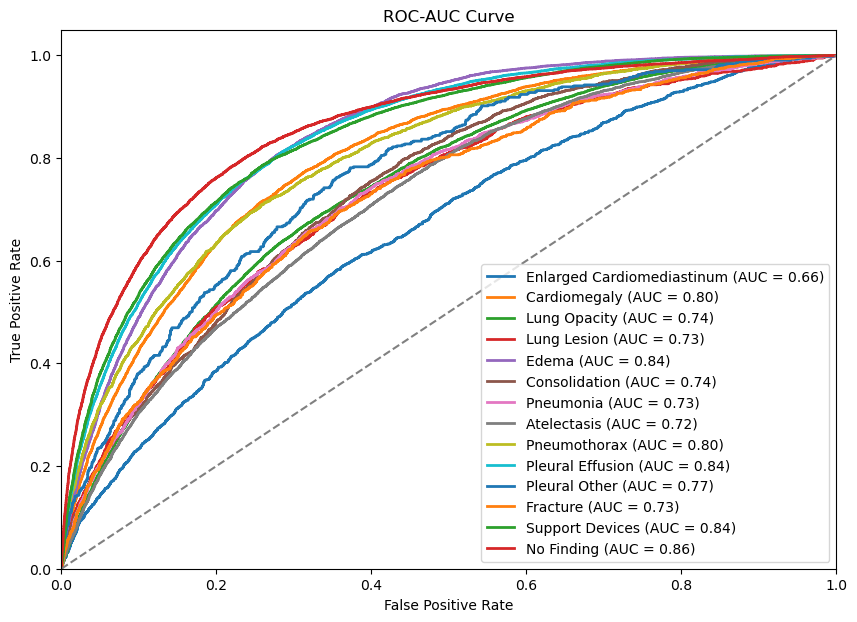

In [100]:
# Plot ROC-AUC curve for each class
plt.figure(figsize=(10, 7))
for i, label_name in enumerate(labels_Columns):
    fpr, tpr, _ = roc_curve(df_test[labels_Columns].values[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{label_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc="lower right")
plt.show()

## Binray Classification

* Create a list of thresholds, calculate each threshold's precision, recall, and f1 score, and then return the threshold that produces the highest f1 score all based on validation set.


In [101]:

def make_pred_multilabel(model, test_dataset, validation_dataset, test_df):
  
    #Load  pre-trained Keras model
    PRED_LABELS = labels_Columns

    for mode in ["Threshold", "test"]:
        # Create empty dataframes
        pred_df = pd.DataFrame(columns=["path"])
        bi_pred_df = pd.DataFrame(columns=["path"])
        true_df = pd.DataFrame(columns=["path"])

        if mode == "Threshold":
            data = validation_dataset  # Use validation dataset for threshold mode
            Eval_df = pd.DataFrame(columns=["label", 'bestthr'])
            thrs = []

        if mode == "test":
            data = test_dataset  # Use test dataset for test mode
            index=0
            TestEval_df = pd.DataFrame(columns=["label", 'auc', "auprc","accuracy"])

            Eval = pd.read_csv("./biomedclip-embedding/Threshold.csv")  # Load threshold values from the CSV
            Eval.head(14)
            thrs = [Eval["bestthr"][Eval[Eval["label"] == label].index[0]] for label in PRED_LABELS]

            print("thrs :",thrs)

        for inputs, labels in data:
            # Get predictions from the pre-trained model
            # inputs = tf.constant(inputs, dtype=tf.float32)
            true_labels = labels.numpy()
            model.set_weights(model.get_weights())

            """ perform inference
              ... use tf.expand_dims(inputs, axis=0) adds an extra dimension at axis 0,
              ... effectively creating a batch of size 1. """

            inputs_batched = tf.expand_dims(inputs, axis=0)
            outputs = model(inputs_batched, training=False)
            probs = outputs.numpy()

            thisrow = {}
            bi_thisrow = {}
            truerow = {}

            thisrow['path']='path'
            truerow['path']='path'

            if mode == "test":
              path=test_df.iloc[index]['path']
              bi_thisrow['path']=path

            # Iterate over each entry in prediction vector; each corresponds to an individual label
            for j, _label in enumerate(PRED_LABELS):
                thisrow["prob_" + _label] = probs[0][j]
                truerow[_label] = true_labels[j]

                if mode == "test":
                   bi_thisrow["bi_" + _label] = probs[0][j] >= thrs[j]

            pred_df = pd.concat([pred_df, pd.DataFrame([thisrow])], ignore_index=True)
            true_df = pd.concat([true_df, pd.DataFrame([truerow])], ignore_index=True)

            if mode == "test":
              #Explicitly cast object-dtype columns with boolean values to bool
              bool_columns = [col_name for col_name in bi_pred_df.columns if col_name != 'path'
               and bi_pred_df[col_name].dtype == 'object']
              bi_pred_df[bool_columns] = bi_pred_df[bool_columns].astype(bool)

              #Append the dictionary to the DataFrame
              bi_pred_df = pd.concat([bi_pred_df, pd.DataFrame([bi_thisrow])], ignore_index=True)
              index=index+1

        #print(f'Last indext in thershold : {index}')
        for column in true_df:
          if column not in PRED_LABELS:
            continue
          actual = true_df[column]
          pred = pred_df["prob_" + column]

          thisrow = {}
          thisrow['label'] = column
          if mode == "test":
            bi_pred = bi_pred_df["bi_" + column]
            thisrow['auc'] = np.nan
            thisrow['accuracy'] = np.nan
            thisrow['auprc'] = np.nan
          else:
            thisrow['bestthr'] = np.nan

          try:
            if mode == "test":
              # Calculate the AUC using the true labels and predicted probabilities
              thisrow['auc'] =sklm.roc_auc_score(actual.astype(int),pred)

              thisrow['auprc'] = sklm.average_precision_score(
                  actual.astype(int), pred)

              #Calculate accuracy
              thisrow['accuracy'] = sklm.accuracy_score(actual.astype(int), bi_pred)
            else:

              p, r, t = sklm.precision_recall_curve(actual.astype(int), pred)

              #Calculate F1-score, handling division by zero
              f1_scores = []
              for precision, recall in zip(p, r):
                if precision + recall == 0:
                  f1_scores.append(0.0)  # Handle division by zero
                else:
                  f1_scores.append(2 * (precision * recall) / (precision + recall))

              #Find the threshold that maximizes F1-score
              best_threshold = t[np.argmax(f1_scores)]

              thrs.append(best_threshold)
              thisrow['bestthr'] = best_threshold

          except BaseException as be:
            #Handle the exception
            print(f'can not caclucalte AUC and Accuracy for  : {str(column)}, see the error : {str(be)}')

          if mode == "Threshold":
            Eval_df = pd.concat([Eval_df, pd.DataFrame([thisrow])], ignore_index=True)

          if mode == "test":
            TestEval_df = pd.concat([TestEval_df, pd.DataFrame([thisrow])], ignore_index=True)


        if mode == "Threshold":
          Eval_df.to_csv("./biomedclip-embedding"+"/Threshold.csv", index=False)

        if mode == "test":
          TestEval_df.to_csv("./biomedclip-embedding/TestEval.csv", index=False)
          bi_pred_df.to_csv("./biomedclip-embedding/bipred.csv", index=False)


    avg_AUC=TestEval_df['auc'].sum()/14.0
    avg_accuracy=TestEval_df['accuracy'].sum() /14.0

    print("AUC ave:", round(avg_AUC,2))
    #print("auprc ave:", TestEval_df['auprc'].sum() / 14.0)
    print("Accuracy ave:", round(avg_accuracy,2))
    print("done")
  
    #return pred_df, Eval_df, bi_pred_df,TestEval_df

In [102]:
#path_image = path_to_image_files  # Replace with the path to your image files
make_pred_multilabel(model,test_dataset,validation_dataset,df_test)

C:\Users\gebre\AppData\Local\Temp\ipykernel_16480\3284196369.py:124: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Eval_df = pd.concat([Eval_df, pd.DataFrame([thisrow])], ignore_index=True)


thrs : [0.07254994, 0.21267019, 0.3249685, 0.093154036, 0.28365746, 0.11670005, 0.092336625, 0.22193074, 0.1527824, 0.3686368, 0.050227217, 0.075364314, 0.41229272, 0.2983403]


C:\Users\gebre\AppData\Local\Temp\ipykernel_16480\3284196369.py:127: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  TestEval_df = pd.concat([TestEval_df, pd.DataFrame([thisrow])], ignore_index=True)


AUC ave: 0.77
Accuracy ave: 0.82
done
